In [8]:

import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['figure.dpi'] = 600

Chapter 17 of {cite}`zaki2020data`: [Clustering Validation](https://www.cs.rpi.edu/~zaki/DMML/slides/pdf/ychap17.pdf)

# Clustering Validation Metrics

## Introduction to Clustering Validation

Clustering validation helps assess the quality of clustering results. There are three main types of validation measures:

1. **External measures**: Use external information like ground truth labels
2. **Internal measures**: Use only the data and clustering results
3. **Relative measures**: Compare different clusterings

## External Measures

External measures assume that the correct or  ground-truth clustering is known *a priori*, which  is used to evaluate a given clustering.  

Let $\mathbf{D} = \{\mathbf{x}_i\}_{i=1}^n$ be a dataset consisting of $n$ points in a  $d$-dimensional space, partitioned into $k$ clusters. Let $y_i \in  
\left\{ 1, 2,\ldots , k \right\}$ denote the ground-truth cluster  membership or label information for each point.  

The ground-truth clustering is given as:  

$$
\mathbf{T} = \left\{ T_1, T_2, \ldots, T_k \right\}
$$

where the cluster $T_{j}$ consists of all the points with label $j$, i.e.,  

$$
T_{j} = \left\{ \mathbf{x}_i \in \mathbf{D} \mid y_i = j \right\}
$$

We refer to $\mathbf{T}$ as the ground-truth *partitioning*, and to each $T_i$ as a *partition* (class).  

Let $\mathbf{C} = \{C_1, \ldots, C_r\}$ denote a clustering of the same dataset into $r$  clusters, obtained via some clustering algorithm, and let $\hat{y}_i \in  
\left\{ 1, 2, \ldots, r \right\}$ denote the cluster label for $\mathbf{x}_i$.  

External evaluation measures try to capture the extent to which points from the same partition appear in the  same cluster, and the extent to which points from different partitions  are grouped in different clusters.


All of the external measures rely on the $r \times k$  **contingency table** $\mathbf{N}$ that is induced by a clustering $\mathbf{C}$ and the ground-truth partitioning $\mathbf{T}$, defined as follows:  

$$
\mathbf{N}(i,j) = n_{ij}  = \left| C_i \cap T_{j} \right|
$$

The count $n_{ij}$ denotes the number of points that are common to cluster $C_i$ and ground-truth partition $T_{j}$.  

Let $n_{i} = |C_i|$ denote the number of points in cluster $C_i$, and let $m_{j} = |T_{j}|$ denote the number of points in partition  $T_{j}$.  The contingency table can be computed from $\mathbf{T}$ and $\mathbf{C}$ in $O(n)$ time by examining the partition and cluster labels, $y_i$ and  $\hat{y}_i$, for each point $\mathbf{x}_i \in \mathbf{D}$ and incrementing the corresponding count $n_{y_i\hat{y}_i}$. 

Contingency Table can be computed as follows:

In [9]:
import numpy as np

def compute_contingency_table(true_labels, cluster_labels):
    """Compute contingency table efficiently in O(n) time."""
    unique_classes, class_map = np.unique(true_labels, return_inverse=True)    
    unique_clusters, cluster_map = np.unique(cluster_labels, return_inverse=True)

    r, k = len(unique_clusters), len(unique_classes)
    
    # Compute contingency table using NumPy's bincount with a combined index
    contingency_table = np.zeros((r, k), dtype=int)
    np.add.at(contingency_table, (cluster_map, class_map), 1)
    
    return contingency_table

true_labels = np.array([0, 0, 1, 1, 2, 2])
cluster_labels = np.array([0, 1, 1, 2, 2, 0])

print(compute_contingency_table(true_labels, cluster_labels))


[[1 0 1]
 [1 1 0]
 [0 1 1]]


## Efficient Contingency Table Computation with `np.add.at`

When implementing clustering validation metrics, constructing a **contingency table** is a key step. One efficient way to do this in **NumPy** is using `np.add.at`. This method ensures **correct accumulation of counts** when duplicate indices are present.

### Why `np.add.at`?
Unlike simple **indexed incrementation**, such as:
```python
contingency_table[cluster_map, class_map] += 1
```
NumPy’s **fancy indexing** creates a temporary copy, meaning updates to repeated indices may not accumulate correctly. Instead, `np.add.at` ensures in-place modifications:

```python
np.add.at(contingency_table, (cluster_map, class_map), 1)
```

### Example: Difference Between Direct Indexing and `np.add.at`
Here’s an example illustrating how `np.add.at` correctly handles duplicate indices while direct indexing may fail:

In [10]:
import numpy as np

def compute_contingency_table_direct(true_labels, cluster_labels):
    """Compute contingency table using direct indexing (incorrect for duplicates)."""
    unique_classes, class_map = np.unique(true_labels, return_inverse=True)    
    unique_clusters, cluster_map = np.unique(cluster_labels, return_inverse=True)

    r, k = len(unique_clusters), len(unique_classes)
    
    contingency_table = np.zeros((r, k), dtype=int)
    contingency_table[cluster_map, class_map] += 1  # Direct indexing
    
    return contingency_table

In [11]:
import numpy as np

true_labels = np.array([0, 0, 1, 1, 1, 2, 2, 2, 2])
cluster_labels = np.array([0, 1, 1, 1, 1, 2, 2, 2, 2])

contingency_table_at = compute_contingency_table(true_labels, cluster_labels)
contingency_table_direct = compute_contingency_table_direct(true_labels, cluster_labels)

print("Using direct indexing:")
print(contingency_table_direct)

print("\nUsing np.add.at:")
print(contingency_table_at)


Using direct indexing:
[[1 0 0]
 [1 1 0]
 [0 0 1]]

Using np.add.at:
[[1 0 0]
 [1 3 0]
 [0 0 4]]


### 1. Purity

Purity measures how "pure" each cluster is by the fraction of points from the majority class:

$$
\text{purity} = \frac{1}{n}\sum_{i=1}^r \max_{j=1}^k \{n_{ij}\}
$$

Where:
- $ n $ = total number of points
- $ r $ = number of clusters
- $ k $ = number of true classes
- $ n_{ij} $ = number of points in cluster $ i $ from class $ j $

In [12]:
def purity_score(cluster_labels, true_labels):
    contingency_matrix = compute_contingency_table(cluster_labels, true_labels)
    return np.sum(np.amax(contingency_matrix, axis=1)) / np.sum(contingency_matrix)

Let's consider an example where we achieve **high purity**, ensuring our clustering is well-aligned with the ground-truth partitioning.

### **Example Data**
Suppose we have the following clustering and ground-truth labels:
```python
true_labels    = np.array([0, 0, 1, 1, 1, 2])
cluster_labels = np.array([0, 0, 1, 1, 2, 2])
```
Here, each cluster aligns better with a single true class.

### **Compute Contingency Table**
Using the `compute_contingency_table` function, we obtain:

|   | Class 0 | Class 1 | Class 2 |
|---|--------|--------|--------|
| C₀ | 2 | 0 | 0 |
| C₁ | 0 | 2 | 0 |
| C₂ | 0 | 1 | 1 |

### **Middle Computations**
**Step 1:** Find the max of each row:
- `max(C₀) = 2`  
- `max(C₁) = 2`  
- `max(C₂) = 1`  

**Step 2:** Sum the max values:
$ \sum \max(n_{ij}) = 2 + 2 + 1 = 5 $

**Step 3:** Compute purity:
$
\text{Purity} = \frac{\sum \max(n_{ij})}{\sum n_{ij}} = \frac{5}{6} \approx 0.833
$

In [13]:
true_labels = np.array([0, 0, 1, 1, 1, 2])
cluster_labels = np.array([0, 0, 1, 1, 2, 2])

score = purity_score(cluster_labels, true_labels)
print(f"Purity Score: {score:.3f}")  # Expected output: 0.833

Purity Score: 0.833


**purity is invariant to cluster labels**, meaning that relabeling clusters doesn't change the score as long as the assignment itself remains consistent.

Let's take the previous clustering but **shift the cluster labels** (e.g., renaming clusters **C₀ → C₂**, **C₁ → C₀**, **C₂ → C₁**):

In [14]:
import numpy as np

# Original clustering labels
true_labels            = np.array([0, 0, 1, 1, 1, 2])
cluster_labels         = np.array([0, 0, 1, 1, 2, 2])
shifted_cluster_labels = np.array([2, 2, 0, 0, 1, 1]) # Shifted cluster labels (mapping: 0 → 2, 1 → 0, 2 → 1)

# Compute purity scores for both cases
original_purity = purity_score(cluster_labels, true_labels)
shifted_purity = purity_score(shifted_cluster_labels, true_labels)

print(f"Original Purity: {original_purity:.3f}")  # Expected output: 0.833
print(f"Shifted Labels Purity: {shifted_purity:.3f}")  # Expected output: 0.833 (same!)

Original Purity: 0.833
Shifted Labels Purity: 0.833



**Why Does Purity Stay the Same?**
- The **mapping between clusters and ground-truth partitions hasn't changed**, only their labels.
- Since purity only depends on **how well clusters match ground-truth partitions**, renaming clusters **doesn't affect** purity calculations.

## Precision and Recall

For each cluster $ C_i $:

- **Precision**: Fraction of points in cluster from majority class
- **Recall**: Fraction of points from class found in cluster

![](img/Precisionrecall.png)



### Precision  
Given cluster $C_i$, let $j_i$ denote the partition that contains the maximum number of points from $C_i$,
that is, $j_i = \max_{j=1}^k \{ n_{ij} \}$. 
The precision of a cluster $C_i$ is the same as its purity:

$$
\mathit{prec}_i = \frac{1}{n_{i}}\max_{j=1}^k \left\{ n_{ij} \right\} =
\frac{n_{ij_i}}{n_i}
$$

### Recall  
The recall of cluster $C_i$ is defined as:

$$
\mathit{recall}_i = \frac{n_{ij_i}}{|\mathbf{T}_{j_i}|} =\frac{n_{ij_i}}{m_{j_i}}
$$

where $m_{j_i} = |\mathbf{T}_{j_i}|$.  

### F-Measure  
The F-measure is the harmonic mean of the precision and recall values for each $C_i$:

$$
F_i = \frac{2}{\frac{1}{\mathit{prec}_i} + \frac{1}{\mathit{recall}_i}} =
\frac{2 \cdot \mathit{prec}_i \cdot \mathit{recall}_i}{\mathit{prec}_i + \mathit{recall}_i} =
\frac{2 \; n_{ij_i}}{n_{i} + m_{j_i}}
$$

The **F-measure** for the clustering $\mathbf{C}$ is the mean of clusterwise F-measure values:

$$
F = \frac{1}{r} \sum_{i=1}^r F_i
$$


### 2. Maximum Matching

Finds the best matching between clusters and true classes to maximize overlap:

$$
\text{match} = \frac{1}{n}\max_M \sum_{(i,j)\in M} n_{ij}
$$

Where $ M $ is a matching between clusters and classes.

**Maximum Weight Matching based on {cite}`zaki2020data`**


Let $G$ be a bipartite graph over the vertex set $V = \mathbf{C} \cup \mathbf{T}$, and let the edge set be $E = \{ (C_i, T_{j}) \}$ with  edge weights $w(C_i,T_{j}) = n_{ij}$.  A **matching** $M$ in $G$ is a subset of $E$, such that the edges in $M$ are pairwise nonadjacent, meaning they do not have a common vertex.

The maximum weight matching in $G$ is given as:

$$
\mathit{match} = \arg \max_M \left\{ \frac{w(M)}{n} \right\}
$$

where $w(M)$ is the sum of all edge weights in matching $M$,  given as $w(M) = \sum_{e \in M} w(e)$.  

### Maximum Matching Example (Bipartite Graph Interpretation)

**Scenario**: Imagine we have clustered 10 fruits into 3 clusters, and we know their true categories (ground truth):

```
True Categories (T₁=apples, T₂=oranges, T₃=bananas):
T₁: apple1, apple2, apple3, apple4
T₂: orange1, orange2, orange3
T₃: banana1, banana2, banana3

Cluster Assignments (C₁, C₂, C₃):
C₁: [apple1, apple2, banana1]
C₂: [orange1, orange2, apple3] 
C₃: [banana2, banana3, orange3, apple4]

```

### Contingency Table

|   | Apples (T₁) | Oranges (T₂) | Bananas (T₃) | Total (nᵢ) |
|---|------------|-------------|-------------|-------------|
| C₁ (apple1, apple2, banana1) | 2 | 0 | 1 | 3 |
| C₂ (orange1, orange2, apple3) | 1 | 2 | 0 | 3 |
| C₃ (banana2, banana3, orange3, apple4) | 1 | 1 | 2 | 4 |
| **Total (mⱼ)** | 4 | 3 | 3 | **n = 10** |


**Step 1: Build the Bipartite Graph**

We create edges between clusters and categories with weights equal to their overlap:

```
Clusters       Categories
   C₁ ------------- T₁ (weight=2: apple1,apple2)
      \------------ T₃ (weight=1: banana1)
   C₂ ------------- T₁ (weight=1: apple3)
      \------------ T₂ (weight=2: orange1,orange2)
   C₃ ------------- T₁ (weight=1: apple4)
      \------------ T₂ (weight=1: orange3)
      \------------ T₃ (weight=2: banana2,banana3)
```

**Step 2: Find Maximum Weight Matching**

We want to match each cluster to at most one category (and vice versa) to maximize total weight:

Possible matching options:
1. Match C₁-T₁ (2), C₂-T₂ (2), C₃-T₃ (2) → Total weight = 6
2. Match C₁-T₃ (1), C₂-T₂ (2), C₃-T₁ (1) → Total weight = 4

The first option gives us the maximum weight matching.

**Step 3: Calculate Maximum Matching Score**

$$
\text{match} = \frac{\text{Total matched weight}}{n} = \frac{2+2+2}{10} = 0.6
$$

In [15]:
import numpy as np
from scipy.optimize import linear_sum_assignment

# Define contingency table
contingency = np.array([
    [2, 0, 1],  # C₁: 2 apples, 0 oranges, 1 banana
    [1, 2, 0],  # C₂: 1 apple, 2 oranges, 0 bananas
    [1, 1, 2]   # C₃: 1 apple, 1 orange, 2 bananas
])

# Find optimal matching
row_ind, col_ind = linear_sum_assignment(contingency, maximize=True)

# Perform indexing correctly
max_weight = contingency[row_ind, col_ind].sum()

print(f"Optimal matching: {list(zip(row_ind, col_ind))}")
print(f"Max weight: {max_weight}")

# Optimal matching: [(0, 0), (1, 1), (2, 2)]  # C₁-T₁, C₂-T₂, C₃-T₃

Optimal matching: [(0, 0), (1, 1), (2, 2)]
Max weight: 6


<!-- **Key Insights**:
1. This ensures one cluster maps to only one true category
2. Unlike purity, we don't double-count categories
3. The score ranges from 0 (worst) to 1 (perfect matching)
4. In our fruit example, 0.6 indicates moderate alignment between clusters and true categories

**Real-world analogy**: Imagine this as assigning each project team (cluster) to exactly one department (category) where you want to maximize the number of correctly assigned team members. -->

### Example 17.1: Good vs Bad Clustering on Iris Data

Let's examine two different clusterings of the Iris dataset using principal components:

#### Good Clustering Results:

![](img/Zaki-Chap17-Good-Clustering.png)

### Contingency Table

|   | iris-setosa | iris-versicolor | iris-virginica | Total (n_i) |
|---|------------|----------------|---------------|-------------|
| C₁ (squares)  | 0  | 47  | 14  | 61  |
| C₂ (circles)  | 50 | 0   | 0   | 50  |
| C₃ (triangles) | 0  | 3   | 36  | 39  |
| **Total (m_j)** | 50 | 50  | 50  | **n = 100** |

**Purity:** 0.887  
**Match:** 0.887  
**F:** 0.885  

#### Bad Clustering Results:

![](img/Zaki-Chap17-Bad-Clustering.png)

### Contingency Table

|   | iris-setosa | iris-versicolor | iris-virginica | Total (n_i) |
|---|------------|----------------|---------------|-------------|
| C₁ (squares)  | 30  | 0   | 0   | 30  |
| C₂ (circles)  | 20  | 4   | 0   | 24  |
| C₃ (triangles) | 0  | 46  | 50  | 96  |
| **Total (m_j)** | 50  | 50  | 50  | **n = 150** |

**Purity:** 0.667  
**Match:** 0.560  
**F:** 0.658  



### 4. Pairwise Measures


First, let's define some key quantities used in external measures:

- **TP (True Positives)**: Pairs in same cluster and same true partition
- **FP (False Positives)**: Pairs in same cluster but different partitions
- **TN (True Negatives)**: Pairs in different clusters and different partitions
- **FN (False Negatives)**: Pairs in different clusters but same partition

Given clustering $\mathbf{C}$ and ground-truth partitioning $\mathbf{T}$, let  $\mathbf{x}_i, \mathbf{x}_{j} \in \mathbf{D}$ be any two points, with $i \ne j$.  Let $y_i$ denote the true partition label and let $\hat{y}_i$ denote the cluster label for  point $\mathbf{x}_i$.  

If both $\mathbf{x}_i$ and $\mathbf{x}_{j}$ belong to the same cluster, that is, $\hat{y}_i =  
\hat{y}_{j}$, we call it a *positive* event, and if they do not belong to the same cluster, that is, $\hat{y}_i \ne \hat{y}_{j}$, we call that a *negative* event.  Depending on whether there is agreement between the cluster labels and  partition labels, there are four possibilities to consider:  

 **True Positives (TP)**  
$\mathbf{x}_i$ and $\mathbf{x}_{j}$ belong to the same  partition in $\mathbf{T}$, and they are also in the same cluster in $\mathbf{C}$. The number of true positive pairs is given as:  

$$
\mathit{TP} = \bigl|\{(\mathbf{x}_i, \mathbf{x}_{j}):\; y_i = y_{j}
\text{ and } \hat{y}_i = \hat{y}_{j} \}\bigr|
$$

 **False Negatives (FN)**  
$\mathbf{x}_i$ and $\mathbf{x}_{j}$ belong to the same partition in $\mathbf{T}$, but they do not belong to the same cluster in $\mathbf{C}$.  The number of false negative pairs is given as:  

$$
\mathit{FN} = \bigl|\{(\mathbf{x}_i, \mathbf{x}_{j}):\; y_i = y_{j}
\text{ and } \hat{y}_i \ne \hat{y}_{j} \}\bigr|
$$

 

 **False Positives (FP)**  
$\mathbf{x}_i$ and $\mathbf{x}_{j}$ do not belong to the  same partition in $\mathbf{T}$, but they do belong to the same cluster in $\mathbf{C}$. The number of false positive pairs is given as:  

$$
\mathit{FP} = \bigl|\{(\mathbf{x}_i, \mathbf{x}_{j}):\; y_i \ne y_{j}
\text{ and } \hat{y}_i = \hat{y}_{j} \}\bigr|
$$

 **True Negatives (TN)**  
$\mathbf{x}_i$ and $\mathbf{x}_{j}$ neither belong to  the same partition in $\mathbf{T}$, nor do they belong to the same cluster in $\mathbf{C}$. The number of such true negative pairs is given as:  

$$
\mathit{TN} = \bigl|\{(\mathbf{x}_i, \mathbf{x}_{j}):\; y_i \ne y_{j}
\text{ and } \hat{y}_i \ne \hat{y}_{j} \}\bigr|
$$



#### Jaccard Coefficient
$$
\text{Jaccard} = \frac{TP}{TP + FN + FP}
$$

#### Rand Index
$$
\text{Rand} = \frac{TP + TN}{TP + FN + FP + TN} = \frac{TP + TN}{\binom{n}{2}}
$$

## Internal Validation Measures

### Silhouette Coefficient

Measures how similar a point is to its own cluster compared to other clusters:

For each point $ x_i $:
$$
s_i = \frac{b_i - a_i}{\max(a_i, b_i)}
$$

Where:
- $ a_i $ = average distance to other points in same cluster
- $ b_i $ = min average distance to points in another cluster

Overall score is average of all $ s_i $.

## Python Example on Iris Dataset

In [17]:
import numpy as np
from sklearn import datasets
from sklearn.cluster import KMeans
from sklearn.metrics import (pairwise_distances, 
                            adjusted_rand_score,
                            silhouette_score)

# Load Iris dataset
iris = datasets.load_iris()
X = iris.data
y = iris.target

# Cluster with K-means
kmeans = KMeans(n_clusters=3, random_state=42)
cluster_labels = kmeans.fit_predict(X)

# External measures
contingency = compute_contingency_table(cluster_labels, y)
print(f"Purity: {purity_score(cluster_labels, y):.3f}")
print(f"Rand Index: {adjusted_rand_score(y, cluster_labels):.3f}")

# Internal measure
print(f"Silhouette Score: {silhouette_score(X, cluster_labels):.3f}")

# Pairwise measures
def pairwise_metrics(y_true, y_pred):
    tp = fp = fn = tn = 0
    n = len(y_true)
    
    for i in range(n):
        for j in range(i+1, n):
            same_cluster = y_pred[i] == y_pred[j]
            same_class = y_true[i] == y_true[j]
            
            if same_cluster and same_class:
                tp += 1
            elif same_cluster and not same_class:
                fp += 1
            elif not same_cluster and same_class:
                fn += 1
            else:
                tn += 1
                
    jaccard = tp / (tp + fn + fp)
    rand = (tp + tn) / (tp + fp + fn + tn)
    
    return jaccard, rand

jaccard, rand = pairwise_metrics(y, cluster_labels)
print(f"Jaccard: {jaccard:.3f}")
print(f"Rand Index: {rand:.3f}")

Purity: 0.887
Rand Index: 0.716
Silhouette Score: 0.551
Jaccard: 0.682
Rand Index: 0.874


## Interpretation of Results

- **Purity**: Higher is better (max 1.0)
- **Rand Index**: Higher is better (max 1.0)
- **Silhouette**: Ranges from -1 to 1, higher is better
- **Jaccard**: Higher is better (max 1.0)

[Wiki of Silhouette](https://en.wikipedia.org/wiki/Silhouette_(clustering))

In [18]:
from sklearn import datasets
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
## Load IRIS dataset
iris = datasets.load_iris()
X = iris.data
y = iris.target
## Instantiate the KMeans models
km = KMeans(n_clusters=3, random_state=42)
# Fit the KMeans model
km.fit_predict(X)
# Calculate Silhoutte Score
score = silhouette_score(X, km.labels_, metric='euclidean')
# Print the score
print('Silhouetter Score: %.3f' % score)

Silhouetter Score: 0.551


In [21]:
# !pip install yellowbrick

0.6810461692117462 0


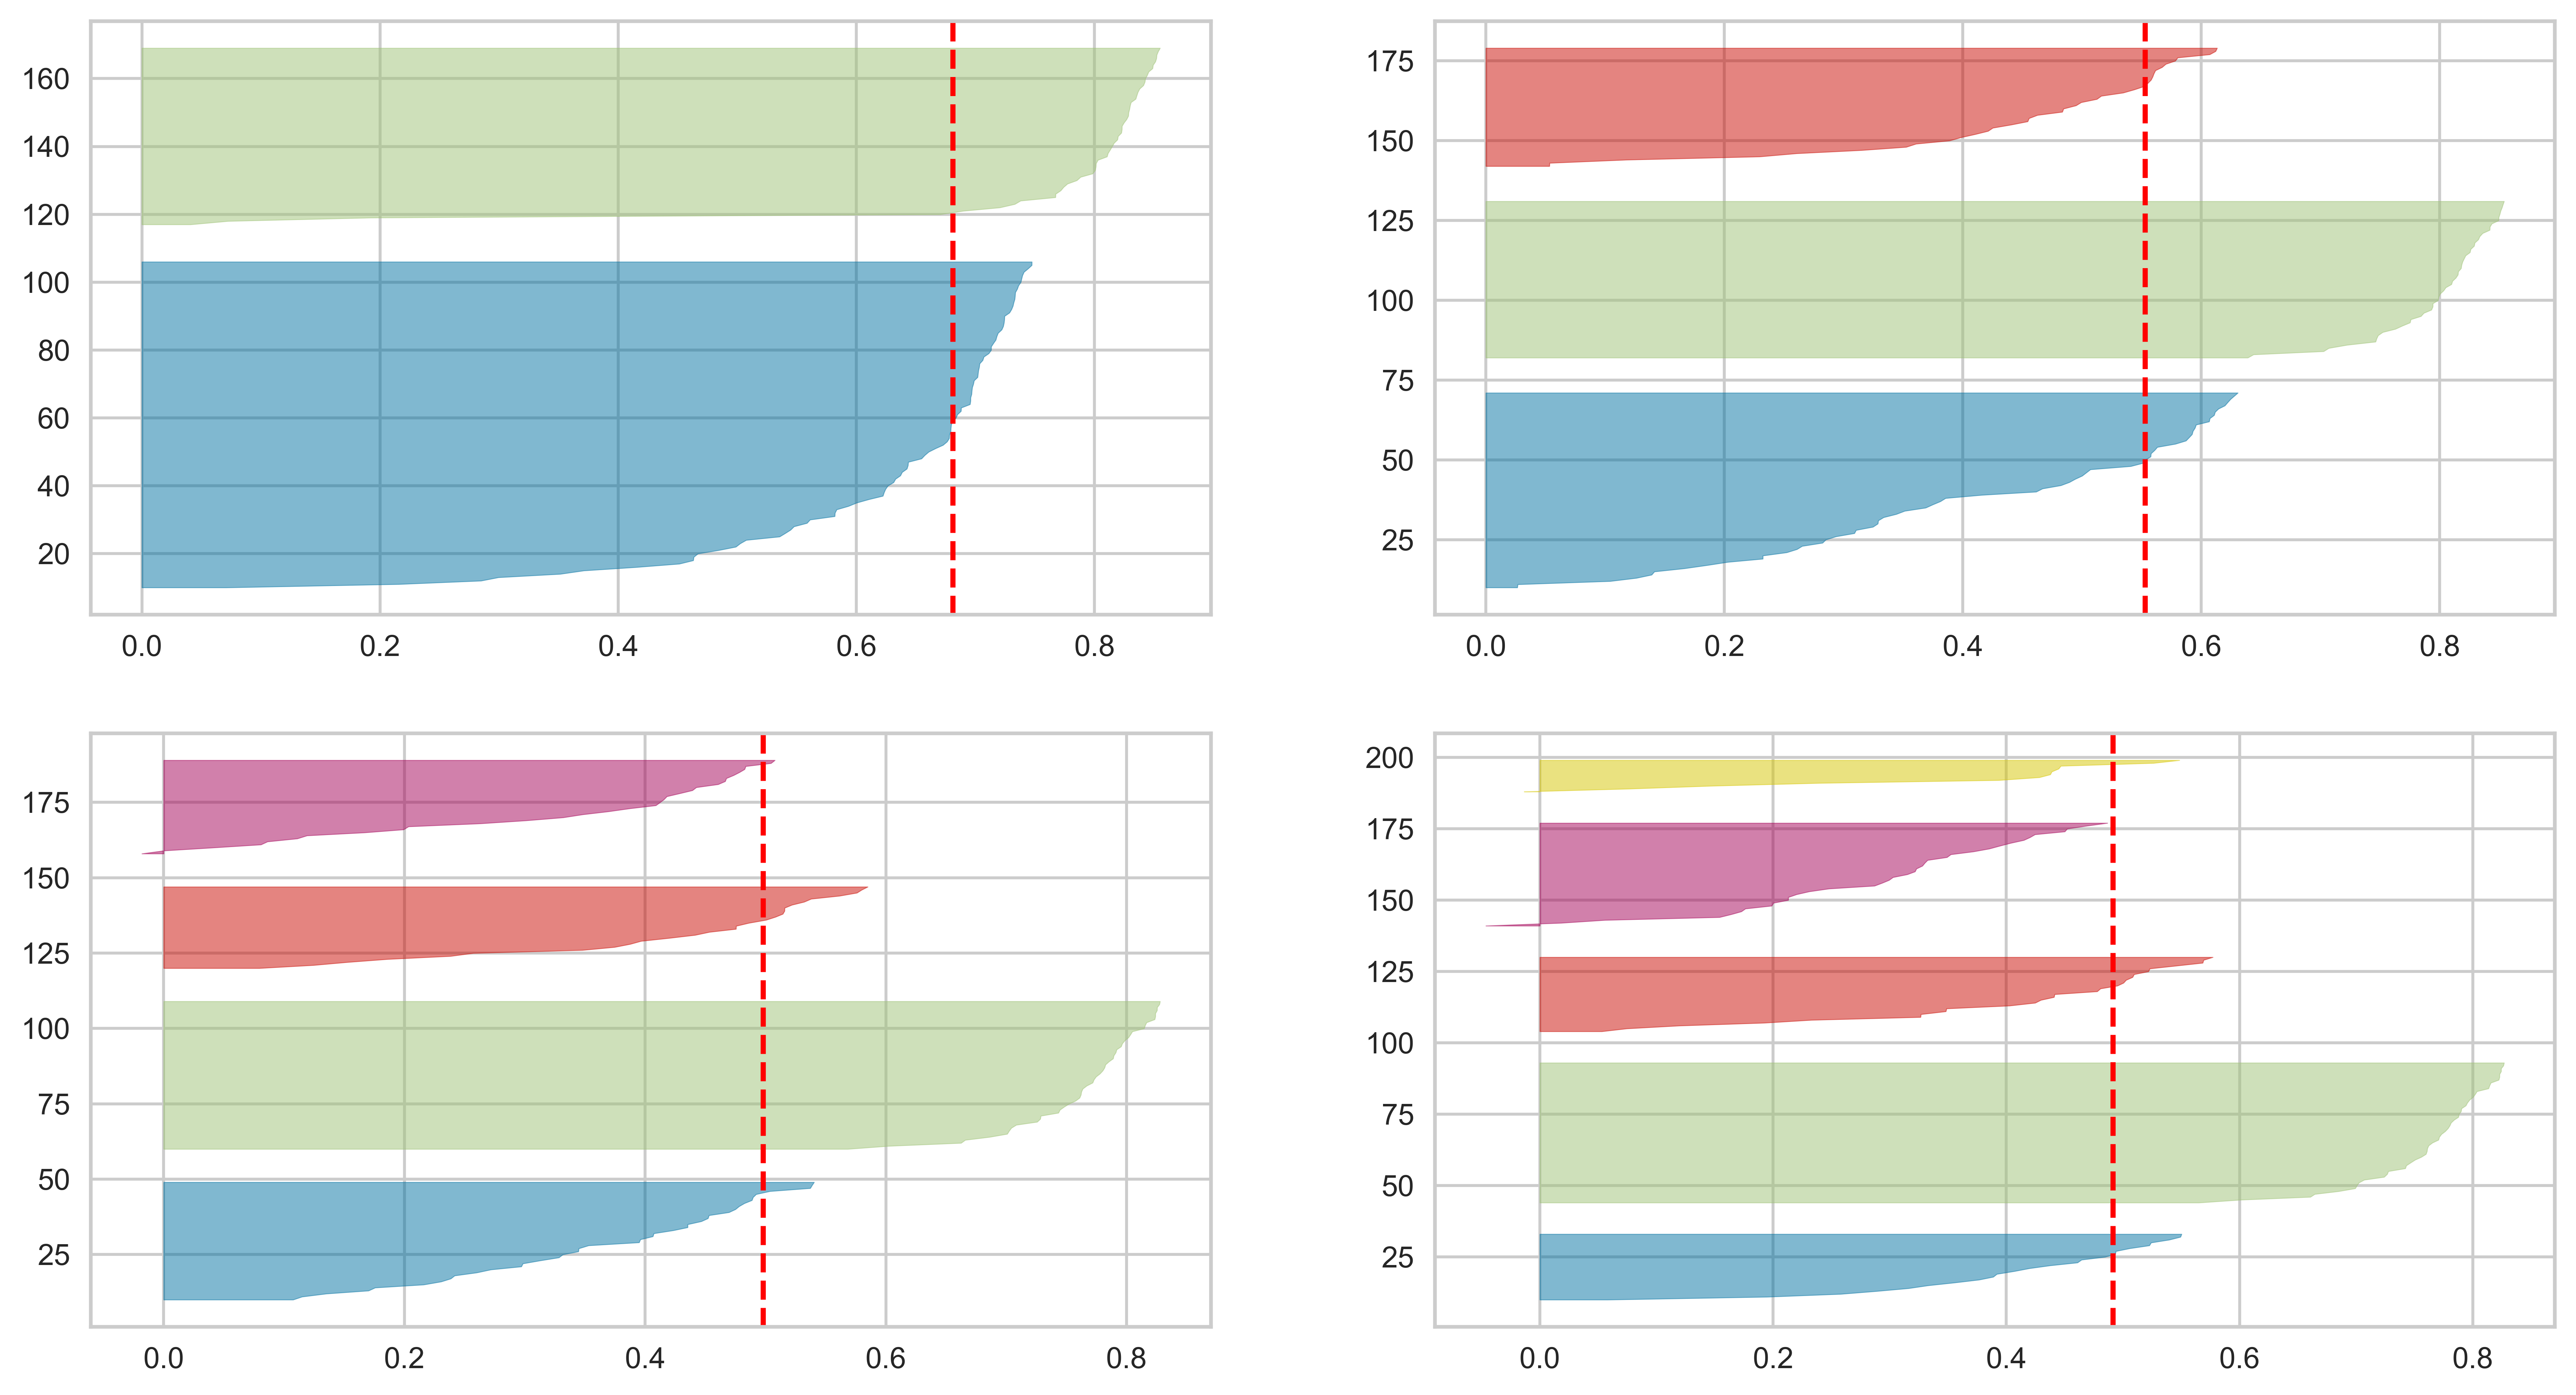

In [22]:
from yellowbrick.cluster import SilhouetteVisualizer
import matplotlib.pyplot as plt

fig, ax = plt.subplots(2, 2, figsize=(15,8))
scores = []
for i in [2, 3, 4, 5]:
    '''
    Create KMeans instance for different number of clusters
    '''
    km = KMeans(n_clusters=i, init='k-means++', n_init=10, max_iter=100, random_state=42)
    # Fit the KMeans model
    km.fit_predict(X)
    # Calculate Silhoutte Score
    score = silhouette_score(X, km.labels_, metric='euclidean')
    scores.append(score)
    q, mod = divmod(i, 2)
    '''
    Create SilhouetteVisualizer instance with KMeans instance
    Fit the visualizer
    '''
    visualizer = SilhouetteVisualizer(km, colors='yellowbrick', ax=ax[q-1][mod])
    visualizer.fit(X)

print(max(scores), scores.index(max(scores)))

## Choosing the Right Metric

1. Use external measures when ground truth is available
2. Use internal measures when no labels exist
3. Consider multiple metrics together for robust evaluation

Remember that no single metric tells the whole story - different metrics may be more appropriate for different clustering goals.


## Further Reading

Here are several real-world examples of bipartite matching problems that help explain the concept of maximum matching in clustering validation, along with relevant links for further reading:

### 1. **Stable Marriage Problem**
**Scenario**: Matching medical students to hospital residency programs based on mutual preferences    
**Visualization**:
```
Students   Hospitals
  A ──────── X (1st choice)
  B ──┬───── Y 
     └───── Z (tie)
  C ──────── Y (only option)
```
**Key Insight**: The Gale-Shapley algorithm finds stable pairings where no unmatched pair prefers each other over their current matches  
**Resource**: [Wikipedia - Stable Marriage Problem](https://en.wikipedia.org/wiki/Stable_marriage_problem)

---

### 2. **Roommate Assignment**
**Scenario**: Matching college students as roommates based on compatibility scores    
**Example Matrix**:
```
       Clean | Social | Studious
Alice    5   |   3    |    2
Bob      2   |   4    |    1
Carol    4   |   1    |    5
```
**Optimal Matching**: Alice-Clean (5), Bob-Social (4), Carol-Studious (5) → Total=14  
**Resource**: [Roommate Assignment Algorithms](https://en.wikipedia.org/wiki/Stable_roommates_problem)

---

### 3. **Thesis Advisor Matching**
**Scenario**: Assigning graduate students to faculty advisors based on research interests  
**Connection**: Similar to ensuring each cluster (advisor group) best represents one true category (research area)  
**Process Flow**:
1. Students rank advisors
2. Advisors rank students
3. Solve using maximum weight matching  
**Visualization**:
```
Students     Research Areas
  Sara ────┐
           ├── ML (Prof. Smith)
  John ────┘
  Emma ────── NLP (Prof. Lee)
```
**Resource**: 
- [Match Day 101: How does the medical residency match work?](https://scopeblog.stanford.edu/2024/03/13/match-day-medical-school-residency/)
- [Dr. Amin Saberi](https://stanford.edu/~saberi)

---

### 4. **Image Feature Matching**
**Scenario**: Matching keypoints between two images of the same object  
**Example**:
```
Image A Features   Image B Features
   Corner X ─────────── Edge P (distance=1.2)
   Blob Y ──┬────────── Corner Q (distance=0.8)
           └────────── Blob R (distance=1.5)
```
**Optimal Matching**: X-P (1.2), Y-Q (0.8) → Total=2.0  
**Algorithm**: Hungarian algorithm on distance matrix  
**Resource**: [OpenCV Feature Matching](https://docs.opencv.org/4.x/dc/dc3/tutorial_py_matcher.html)

---

### 5. **Job Applicant Matching**
**Scenario**: Assigning applicants to job openings based on skill fit    
**Matching Table**:
```
Applicants  Jobs       Fit Score
  Amy ───── Data Sci ─── 0.9
  Sam ──┬── Engineer ── 0.7
        └── Analyst ── 0.8
  Zoe ───── Engineer ── 0.6
```
**Maximum Matching**: Amy-Data Sci (0.9), Sam-Analyst (0.8), Zoe-Engineer (0.6) → Total=2.3  
**Resource**: [LinkedIn Matching Algorithm](https://engineering.linkedin.com/blog/2016/06/how-linkedin-uses-machine-learning-to-match-job-seekers-with-jo)

---

### Comparative Summary Table

| Application          | Cluster Validation Analogy          | Key Metric               | Common Algorithm        |
|----------------------|-------------------------------------|--------------------------|-------------------------|
| Stable Marriage      | Cluster-to-class 1:1 mapping        | Preference satisfaction  | Gale-Shapley            |
| Roommate Assignment  | Intra-cluster homogeneity           | Compatibility score      | Hungarian Algorithm     |
| Advisor Matching     | Aligning clusters with true labels  | Research overlap         | Deferred Acceptance     |
| Image Matching       | Cross-cluster correspondence        | Feature distance         | RANSAC                  |
| Job Applicant        | Purity maximization                 | Skill fit percentage     | Linear Sum Assignment   |

These examples demonstrate how maximum matching principles apply across domains while maintaining the core idea of optimal constrained assignments - exactly what we do when evaluating clustering quality against ground truth.

# Maximum Cardinality Matching in Bipartite Graphs

## Overview
This implementation finds the **maximum cardinality matching** in a **bipartite graph** using NetworkX. A bipartite graph is a graph whose nodes can be split into two disjoint sets such that **no two nodes within the same set** are adjacent.

### Key Components:
- **`bipartite.sets(G)`**: Extracts the two partitions (left and right nodes).
- **`max_weight_matching(G)`**: Finds the optimal matching where each node is paired with at most one other node.

## Code Implementation

Maximum Matching: {('y', 'a'), ('x', 'c')}


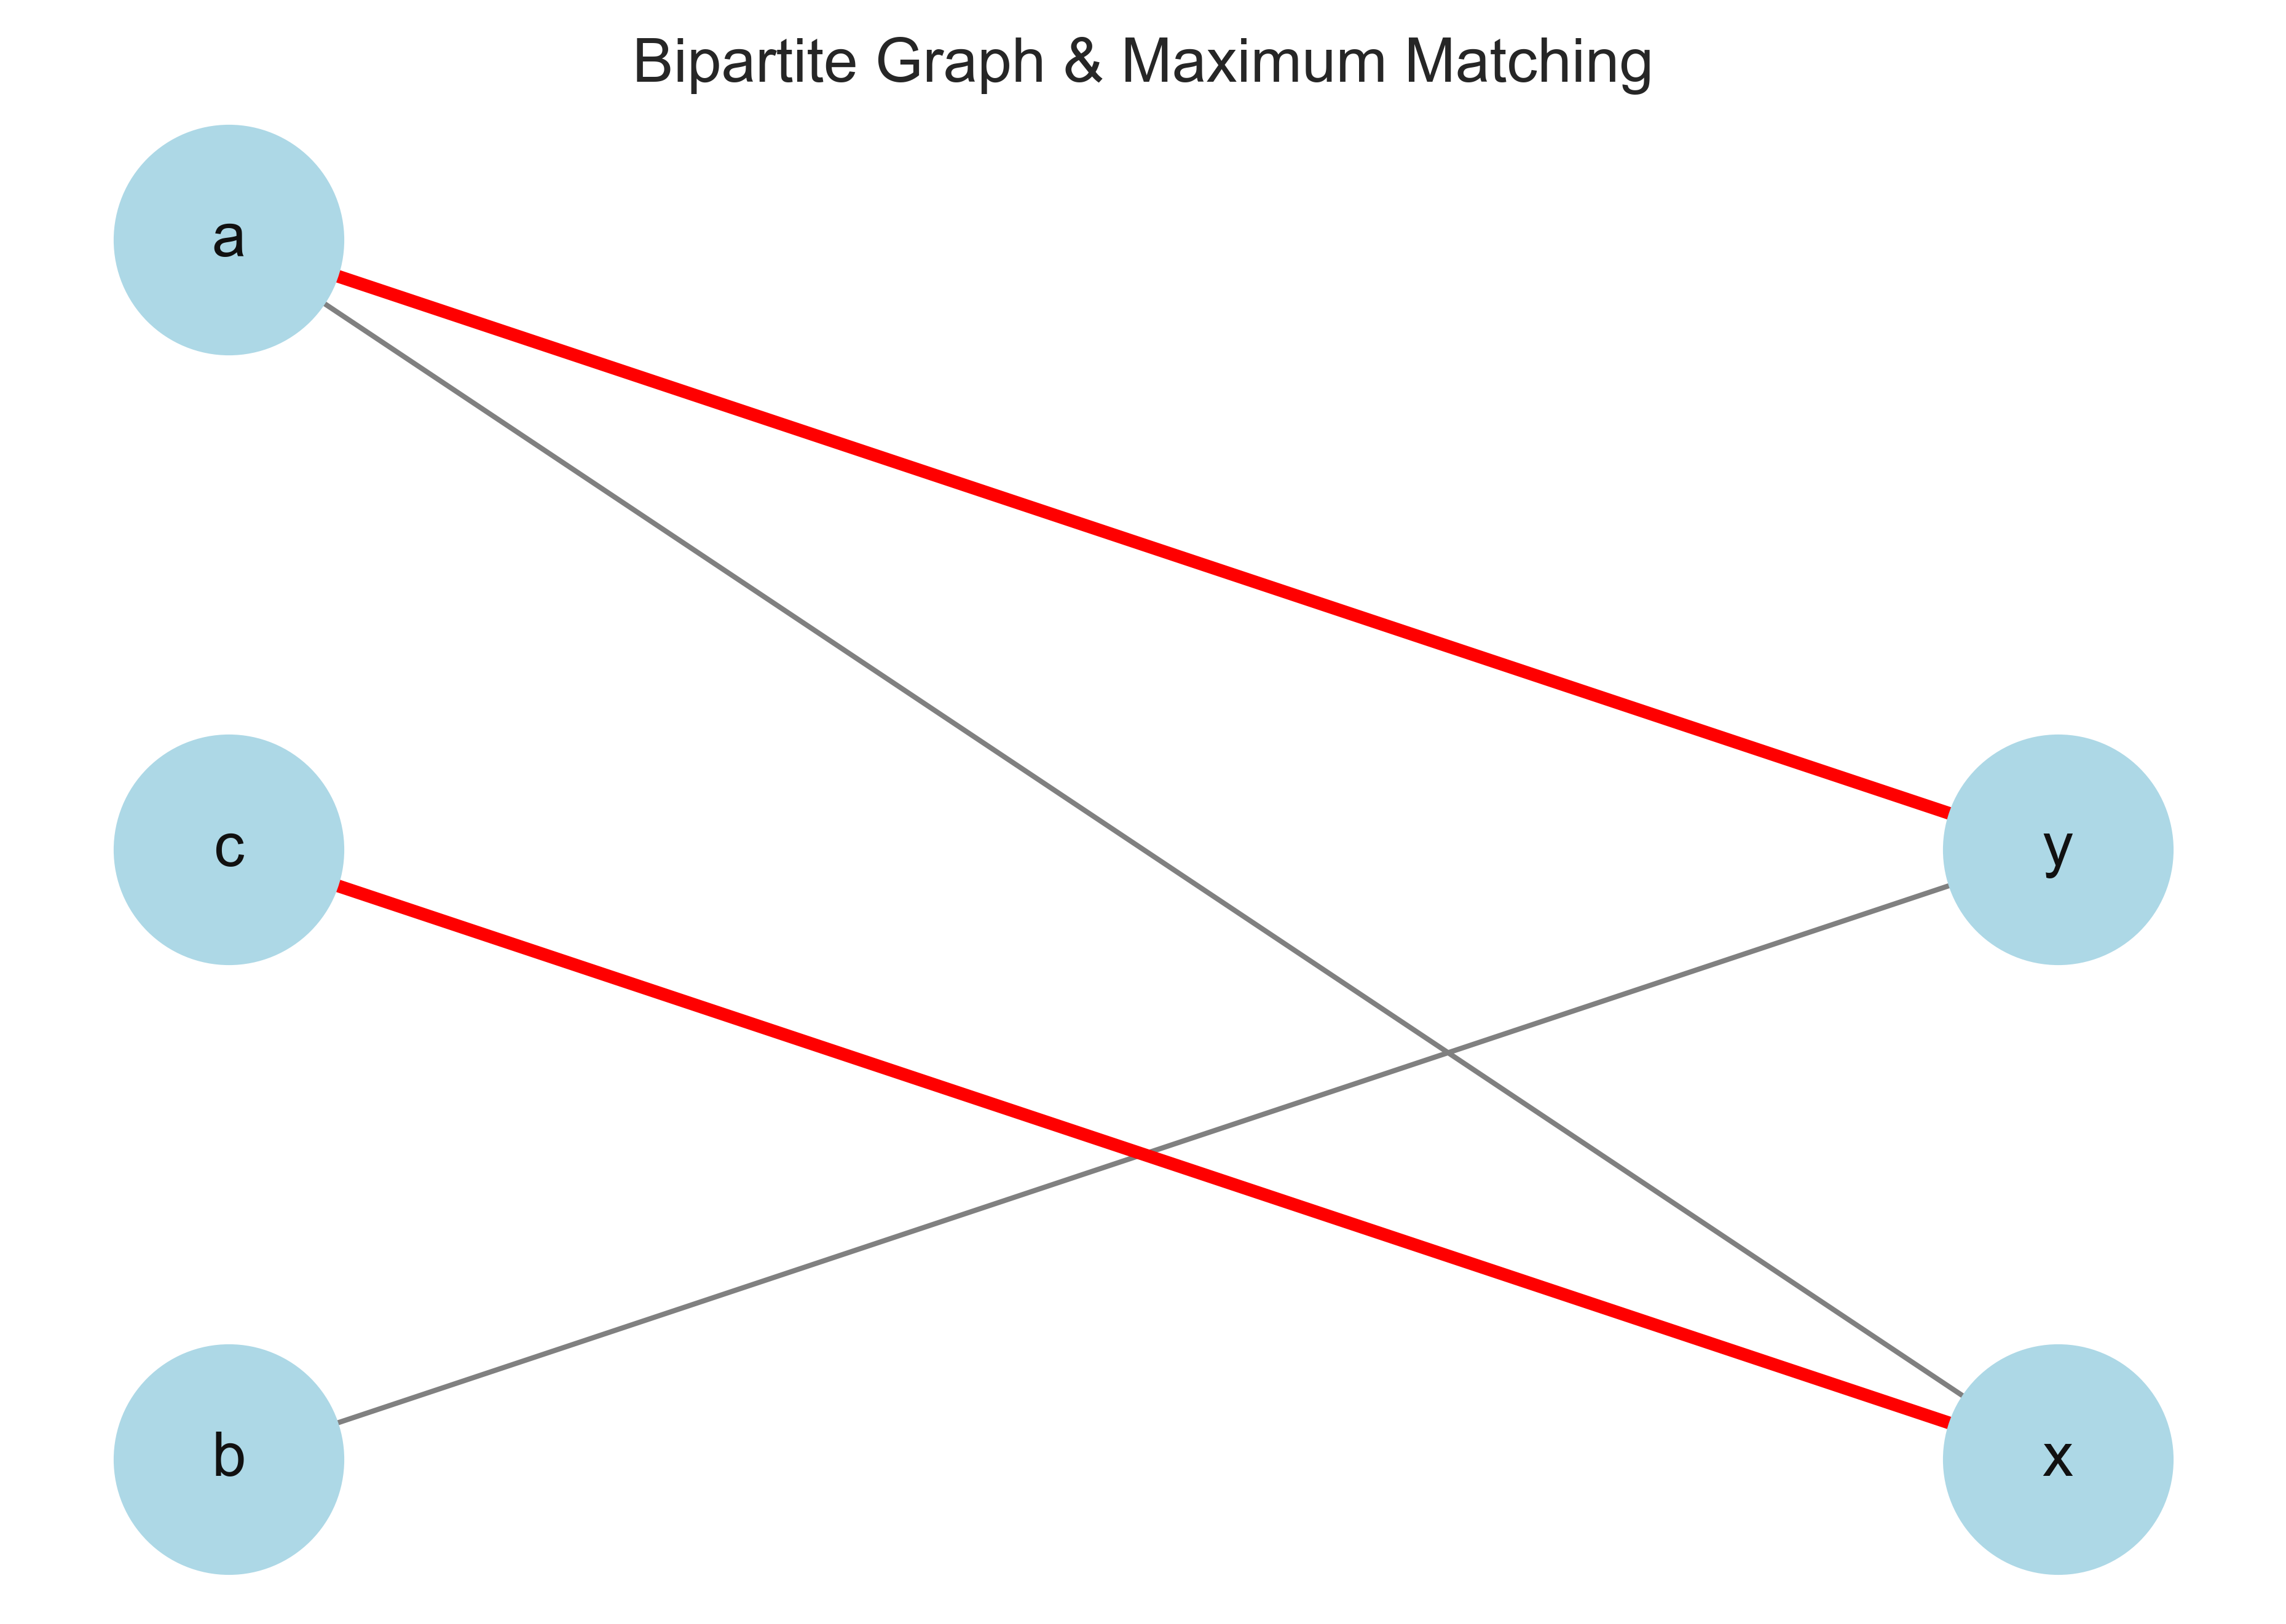

In [27]:
import networkx as nx
import matplotlib.pyplot as plt
from networkx.algorithms import bipartite

def maximum_matching_bipartite_graph(G):
    """
    Return the maximum cardinality matching of a bipartite graph G.
    
    Parameters:
        G (networkx.Graph): Bipartite Graph
        
    Returns:
        (dictionary): Maximum cardinality matching
    """
    left_nodes, right_nodes = bipartite.sets(G)  # Extract partitions
    matching = nx.algorithms.matching.max_weight_matching(G)  # Compute matching
    return matching

# Example Usage
G = nx.Graph()
G.add_nodes_from(['a', 'b', 'c'], bipartite=0)  # Left partition
G.add_nodes_from(['x', 'y'], bipartite=1)  # Right partition
G.add_edges_from([('a', 'x'), ('a', 'y'), ('b', 'y'), ('c', 'x')])

matching = maximum_matching_bipartite_graph(G)
print("Maximum Matching:", matching)

# Visualization of Bipartite Graph and Matching
def draw_bipartite_graph(G, matching):
    pos = {}
    left_nodes, right_nodes = bipartite.sets(G)
    
    for i, node in enumerate(left_nodes):
        pos[node] = (0, i)
    for i, node in enumerate(right_nodes):
        pos[node] = (1, i)
    
    plt.figure(figsize=(6, 4))
    nx.draw(G, pos, with_labels=True, node_color="lightblue", edge_color="gray", node_size=2000, font_size=12)
    
    # Convert set to list of edges
    matching_edges = list(matching)  # Fix: Convert set to list
    
    nx.draw_networkx_edges(G, pos, edgelist=matching_edges, width=2.5, edge_color="red")
    plt.title("Bipartite Graph & Maximum Matching")
    plt.show()

draw_bipartite_graph(G, matching)


Contingency Table

|   | iris-setosa | iris-versicolor | iris-virginica | Total (n_i) |
|---|------------|----------------|---------------|-------------|
| C₁ (squares)  | 30  | 0   | 0   | 30  |
| C₂ (circles)  | 20  | 4   | 0   | 24  |
| C₃ (triangles) | 0  | 46  | 50  | 96  |
| **Total (m_j)** | 50  | 50  | 50  | **n = 150** |

**Purity:** 0.667  
**Match:** 0.560  

Maximum Matching with Edge Weights:
(C₁, iris-setosa) -> Weight: 30
(iris-virginica, C₃) -> Weight: 50
(C₂, iris-versicolor) -> Weight: 4


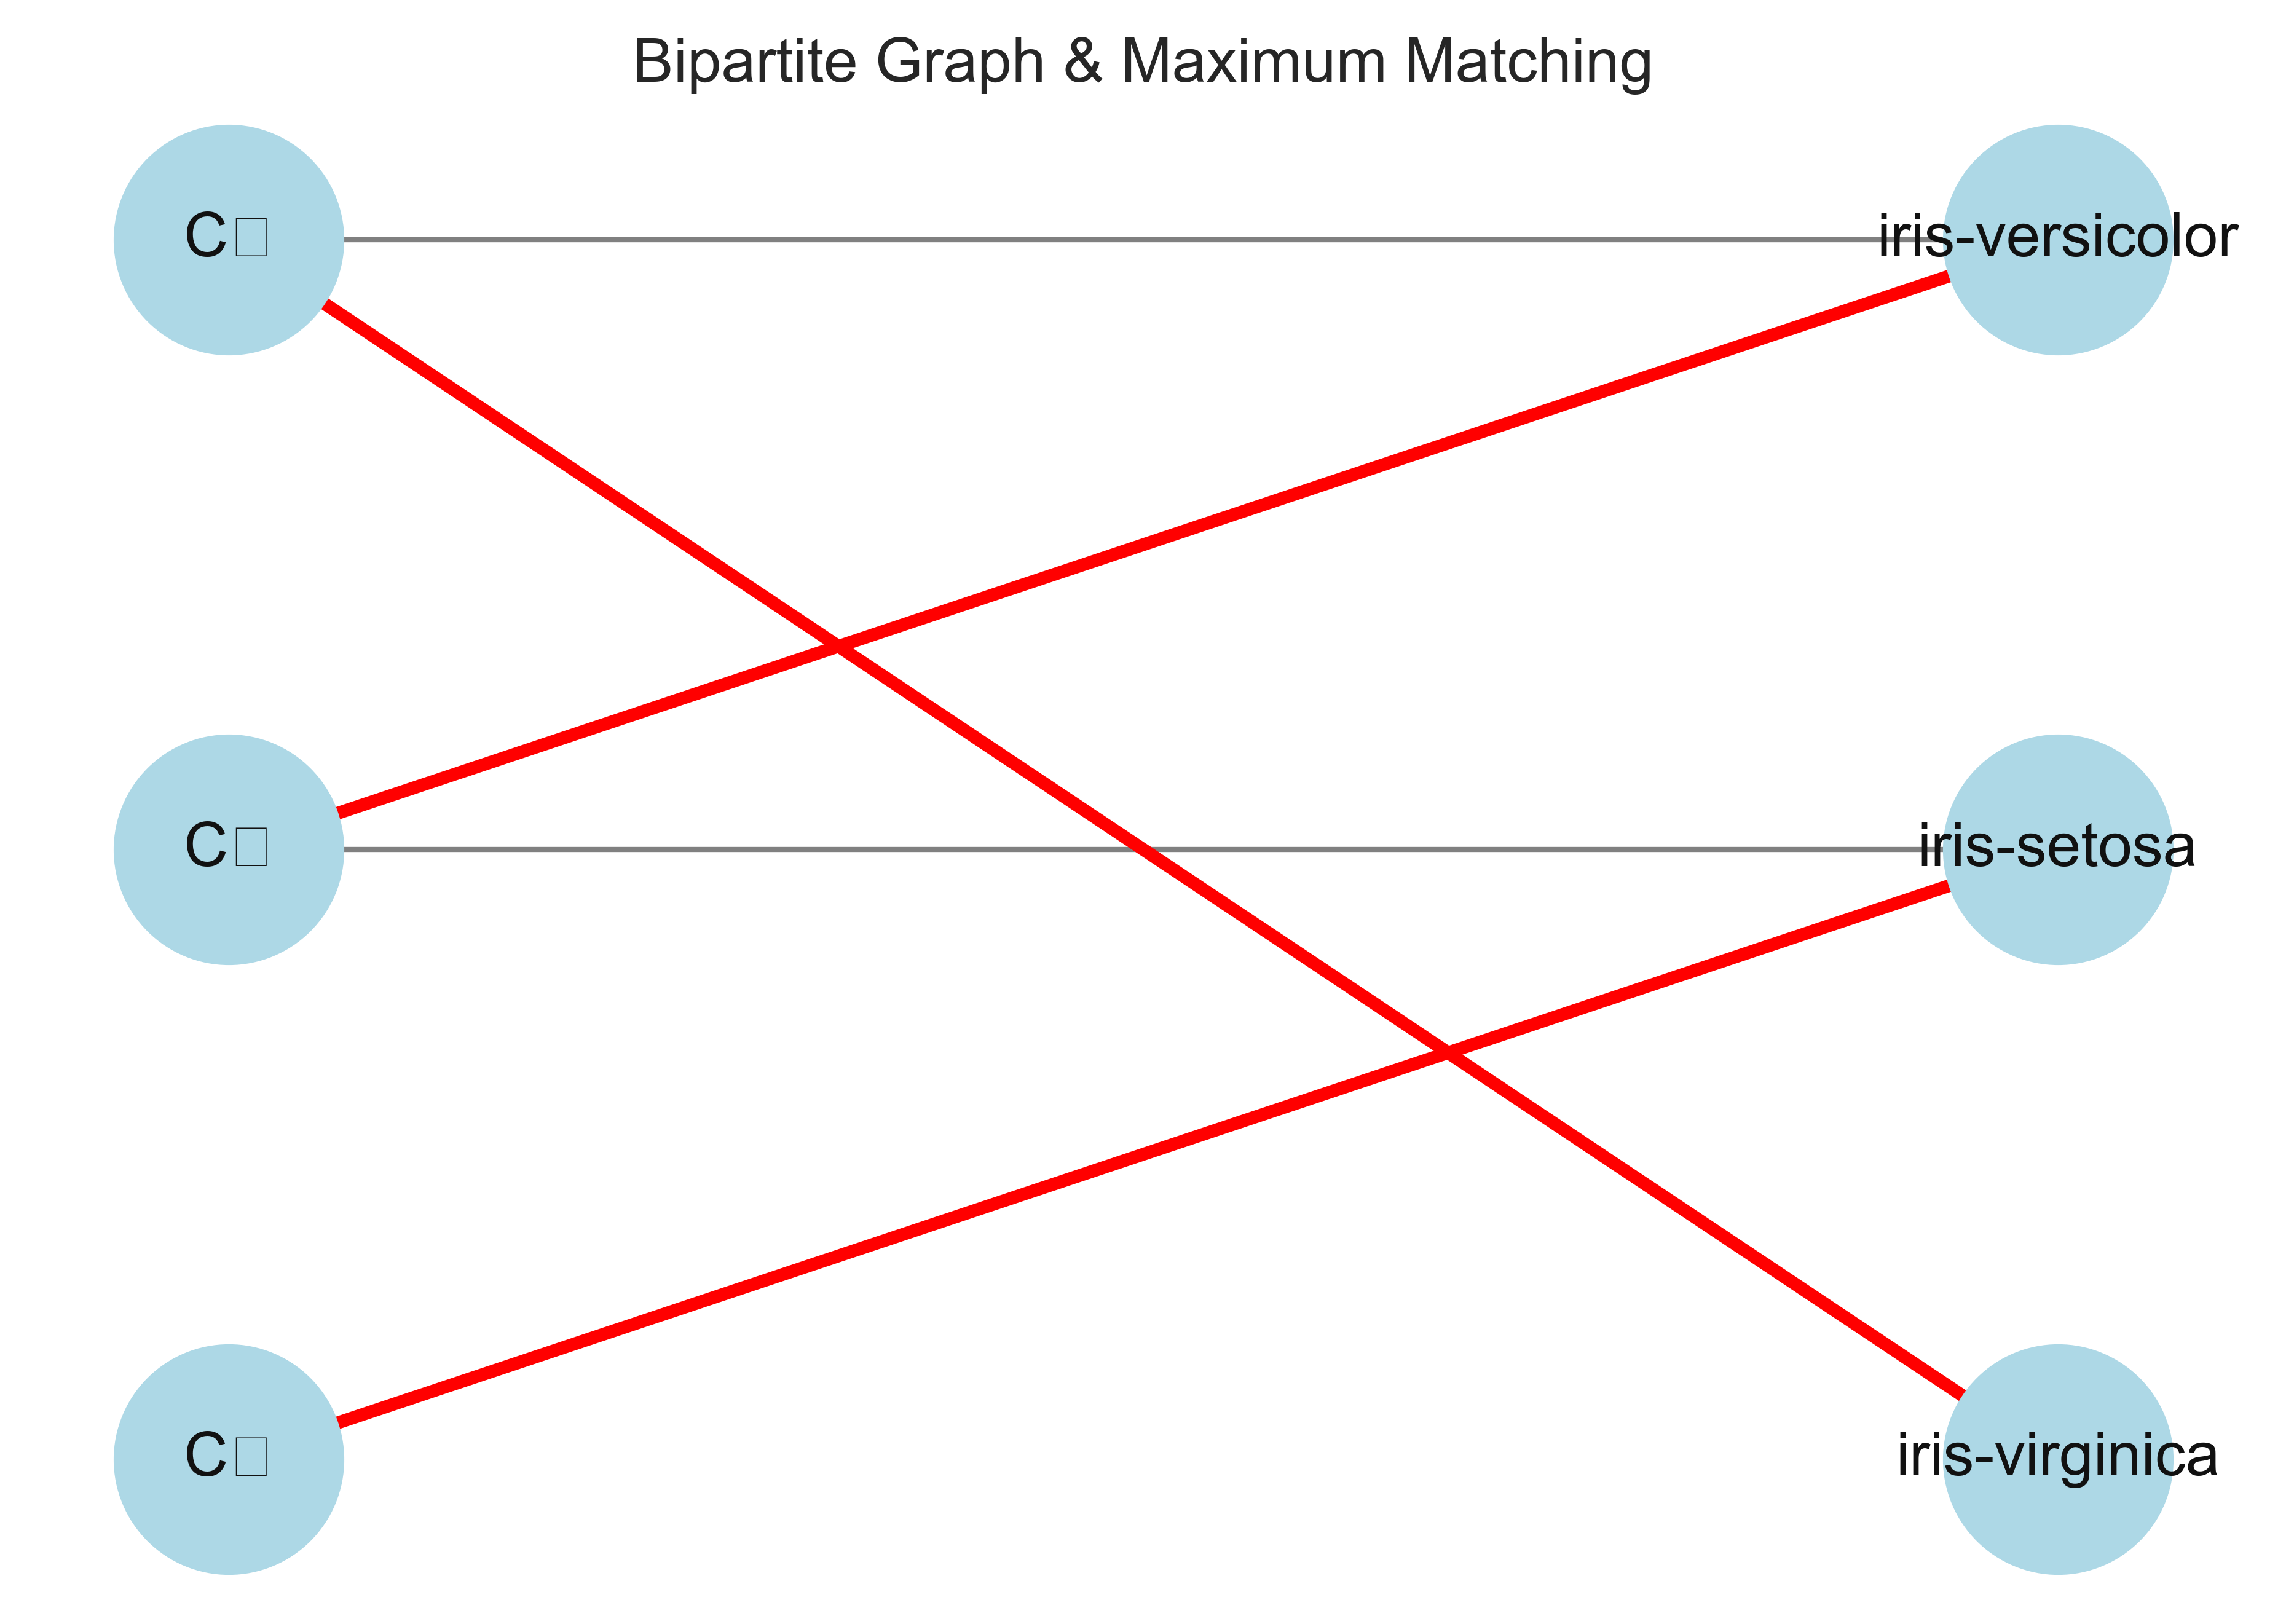

In [29]:
import networkx as nx
from networkx.algorithms import bipartite
import matplotlib.pyplot as plt

def maximum_matching_bipartite_graph(G):
    """
    Return the maximum cardinality matching of a bipartite graph G.
    
    Parameters:
        G (networkx.Graph): Bipartite Graph
        
    Returns:
        (set): Maximum cardinality matching
    """
    matching = nx.algorithms.matching.max_weight_matching(G)  # Compute matching
    return matching

# Construct bipartite graph from contingency table
G = nx.Graph()

# Define clusters and true classes
clusters = ["C₁", "C₂", "C₃"]
true_classes = ["iris-setosa", "iris-versicolor", "iris-virginica"]

# Add nodes with bipartite attributes
G.add_nodes_from(clusters, bipartite=0)  # Cluster labels
G.add_nodes_from(true_classes, bipartite=1)  # True classes

# Add edges with weights from contingency table
edges = [
    ("C₁", "iris-setosa", 30),
    ("C₂", "iris-setosa", 20),
    ("C₂", "iris-versicolor", 4),
    ("C₃", "iris-versicolor", 46),
    ("C₃", "iris-virginica", 50)
]

for u, v, weight in edges:
    if weight > 0:  # Only add edges with non-zero weight
        G.add_edge(u, v, weight=weight)

# Compute maximum matching
matching = maximum_matching_bipartite_graph(G)

# Print matching with weights
print("Maximum Matching with Edge Weights:")
for u, v in matching:
    weight = G[u][v]['weight']  # Extract weight from graph
    print(f"({u}, {v}) -> Weight: {weight}")

# Visualization of Bipartite Graph and Matching
def draw_bipartite_graph(G, matching):
    pos = {}
    left_nodes, right_nodes = bipartite.sets(G)
    
    for i, node in enumerate(left_nodes):
        pos[node] = (0, i)
    for i, node in enumerate(right_nodes):
        pos[node] = (1, i)
    
    plt.figure(figsize=(6, 4))
    nx.draw(G, pos, with_labels=True, node_color="lightblue", edge_color="gray", node_size=2000, font_size=12)

    # Convert matching to a list of edges
    matching_edges = list(matching)  
    
    nx.draw_networkx_edges(G, pos, edgelist=matching_edges, width=2.5, edge_color="red")
    plt.title("Bipartite Graph & Maximum Matching")
    plt.show()

draw_bipartite_graph(G, matching)


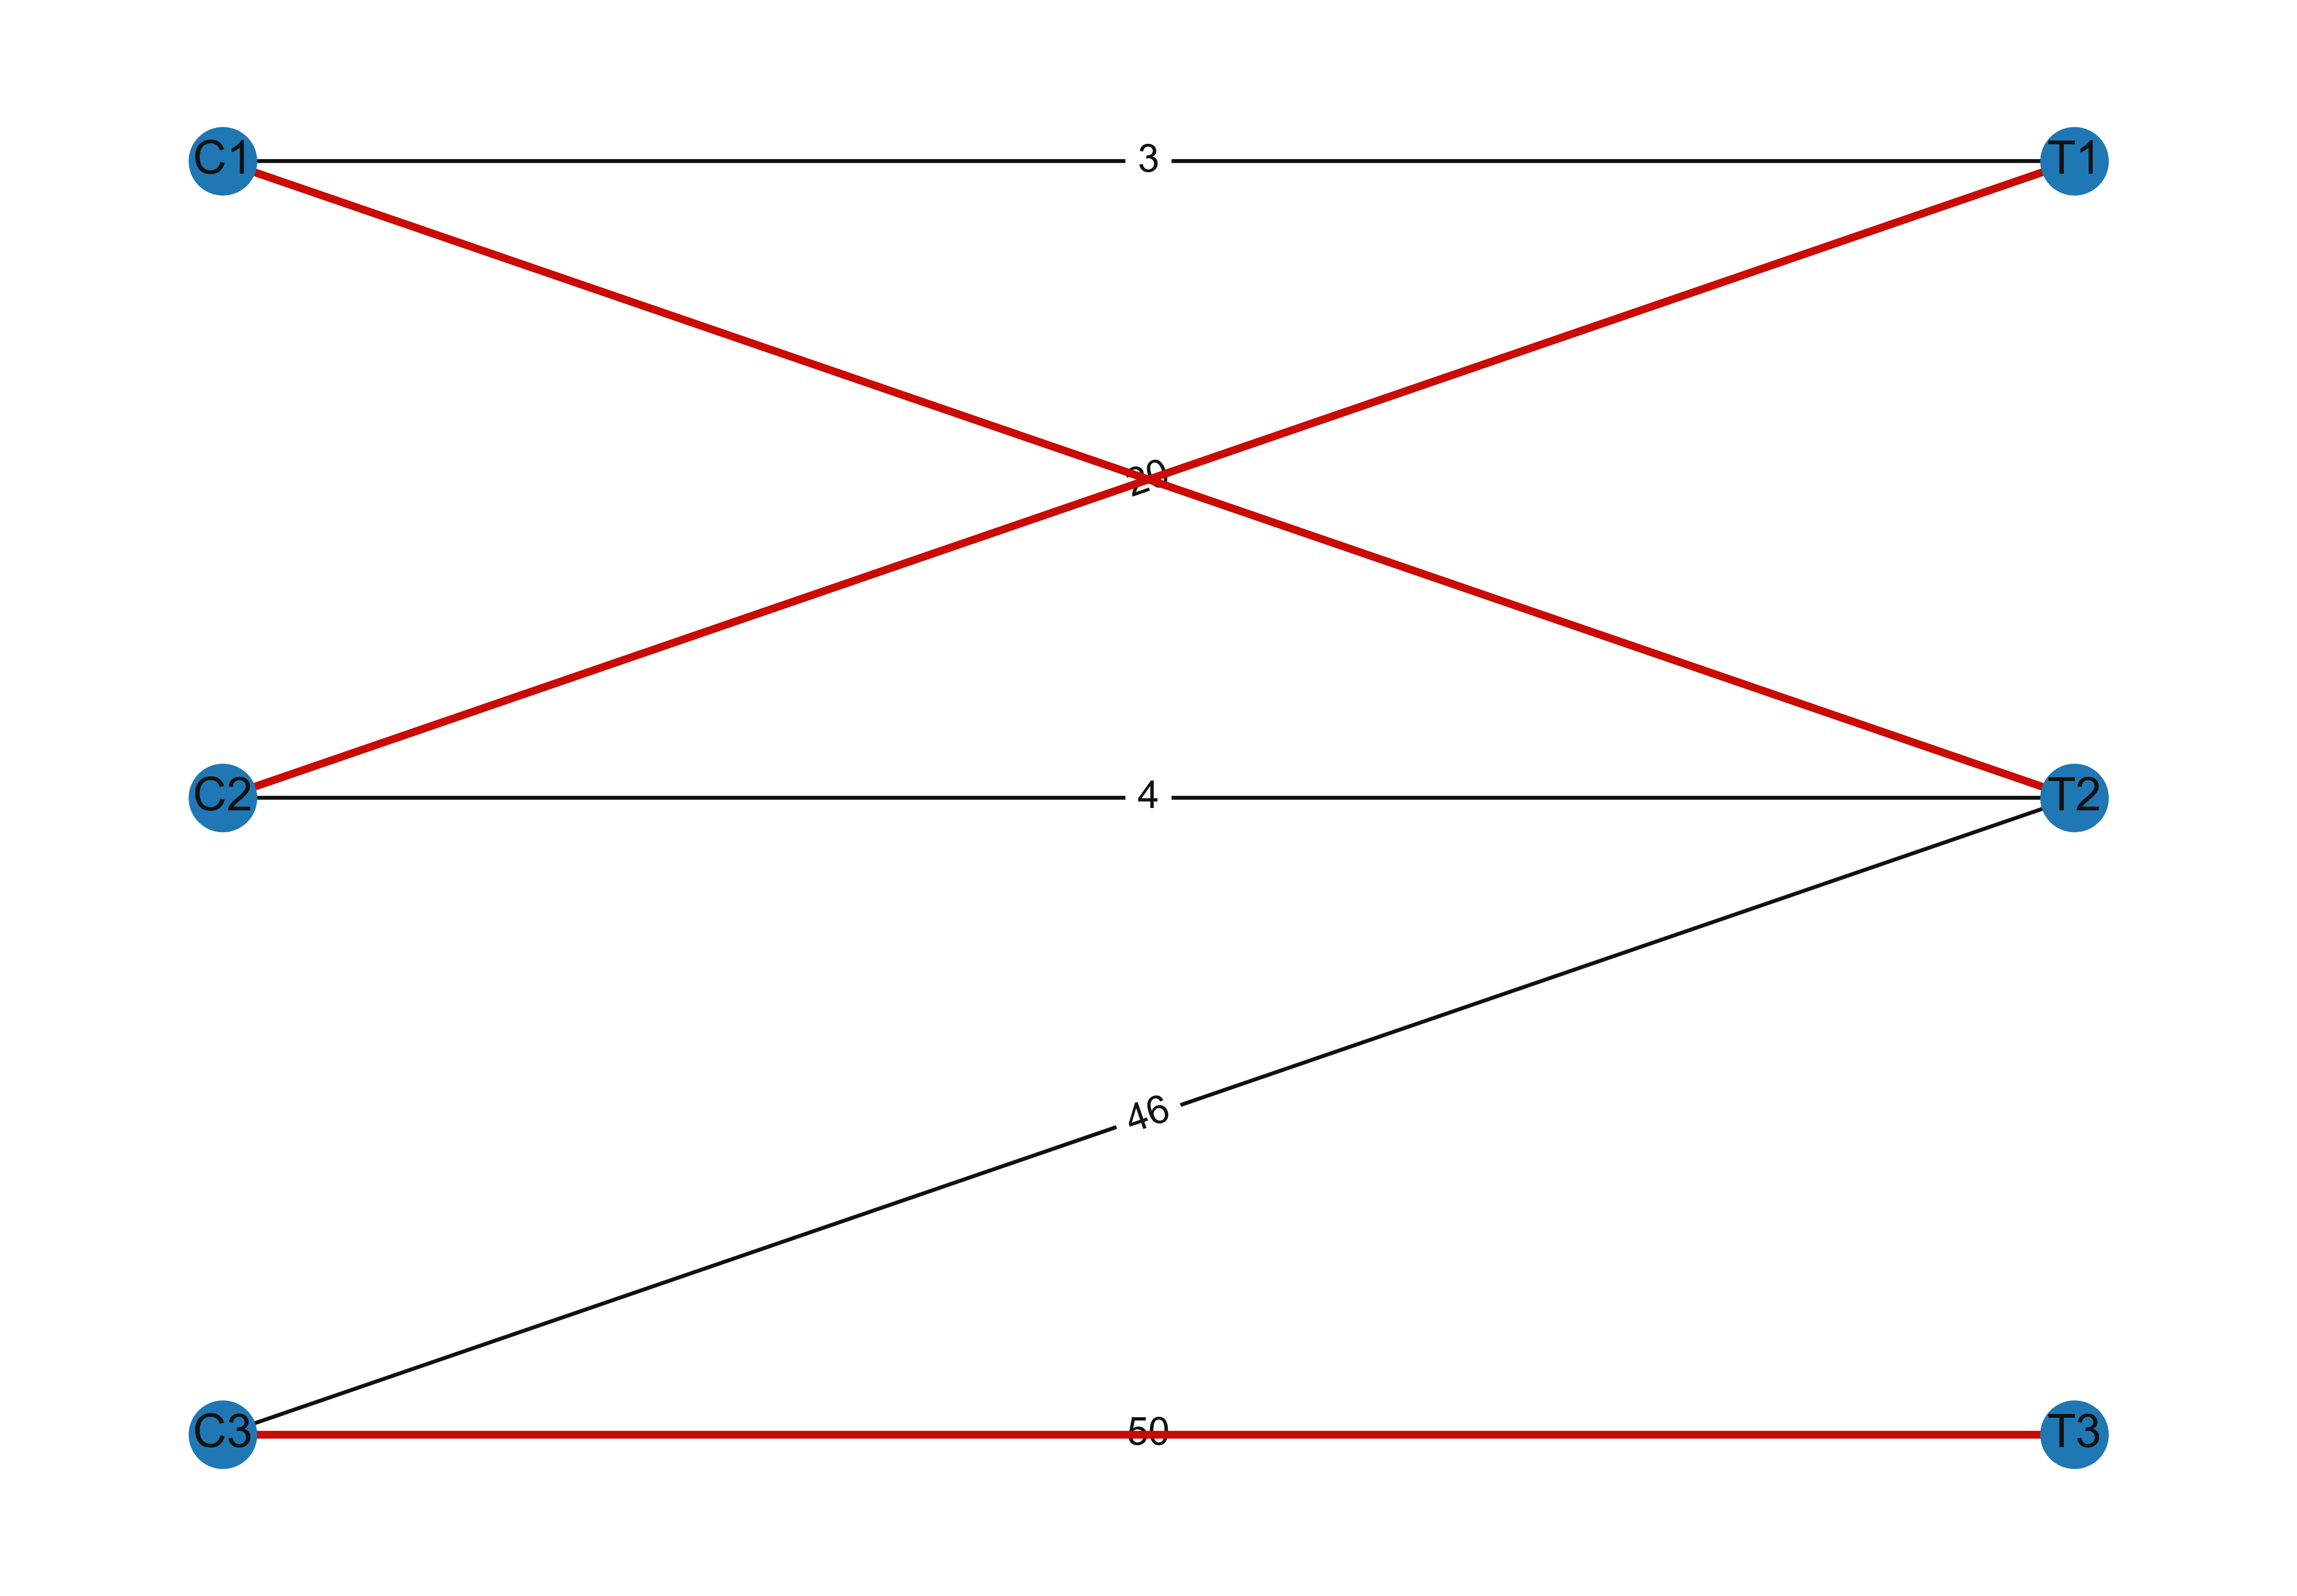

In [25]:
import networkx as nx
from networkx.algorithms import bipartite
import matplotlib.pyplot as plt

def maximum_matching_bipartite_graph(G):
    """
    Return the maximum cardinality matching of a bipartite graph G.
    
    Parameters:
        G (networkx.Graph): Bipartite Graph
        
    Returns:
        (dictionary): Maximum cardinality matching
    """
    left_nodes, right_nodes = bipartite.sets(G)
    matching_edges = nx.algorithms.matching.max_weight_matching(G, weight='weight')
    # Convert matching from list of edges to dictionary format
    matching_dict = dict()
    for u, v in matching_edges:
        matching_dict[u] = v
    return matching_dict

# Example Usage
G = nx.Graph()
G.add_nodes_from(['C1', 'C2', 'C3'], bipartite=0) # Set the node attribute "bipartite" to 0 for nodes in one partition
G.add_nodes_from(['T1', 'T2', 'T3'], bipartite=1) # Set the node attribute "bipartite" to 1 for nodes in the other partition
G.add_weighted_edges_from([('C1', 'T1', 3), ('C1', 'T2', 5),\
                           ('C2', 'T1', 20), ('C2', 'T2', 4),\
                           ('C3', 'T2', 46), ('C3', 'T3', 50)])

# Compute maximum matching
maximum_matching = maximum_matching_bipartite_graph(G)

# Draw bipartite graph
pos = dict()
pos.update( (n, (1, 4-i)) for i, n in enumerate(['C1', 'C2', 'C3']) ) # positions for left nodes
pos.update( (n, (2, 4-i)) for i, n in enumerate(['T1', 'T2', 'T3']) ) # positions for right nodes

# Get edge labels
edge_labels = dict([((u, v), d['weight']) for u, v, d in G.edges(data=True)])

nx.draw(G, pos=pos, with_labels=True)
nx.draw_networkx_edge_labels(G, pos=pos, edge_labels=edge_labels, font_size=10)

# Highlight matched edges
matched_edges = [(u, v) for u, v in maximum_matching.items()]
nx.draw_networkx_edges(G, pos, edgelist=matched_edges, edge_color='r', width=2)

plt.show()
